<center>

# Проект на тему "Поиск экзопланет"
</center>

## Введение

## Часть 1: Импорт необходимых библиотек и загрузка датасета

Выбранный нами [датасет](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative) был взят с сайта NASA. К нашему сожалению или счастью, он обладает исчерпывающей информацией обо всех точках интереса обсерватории Кеплер (Kepler Objects of Interest, `KOI`). 

Каждому рассматриваемому телу соответсвует отдельная строка в датасете, хранящая информацию о статусе тела в рамках программы по поиску экзопланет, а также характеристики самого тела и его "звезды-хозяина".

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts

df = pd.read_csv('cumulative.csv')

# Выведем размер нашего датасета
print(df.shape)

df.head()

(9564, 50)


,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


## Часть 2: Предварительная обработка данных

### Описание колонок

Рассмотрим столбцы нашего датасета, приведем их описание на основании [документации](https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html). Это долгий, но необходимый процесс, так как наш датасет имеет большое количество колонок, и разбор значений каждой позволит нам отбросить очевидно нерелевантные переменные: 

- `kepid`: KepID - уникальный идентификационный номер, присвоенный звезде, около которой ведется поиск планеты. Т.е. несколько тел в нашем датасете могут иметь один KepID, это будет означать, что они обращаются вокруг одной звезды.

- `kepoi_name`: KOI Name - имя-код, присваиваемое объекту интереса Кеплера (далее `KOI`). Если считанные данные похожи на транзит, гипотетической планете присваивается KOI Name.

- `kepler_name` - Имя, присваиваемое объекту, после подтверждения его статуса экзопланеты.

- `koi_disposition` - Финальный вердикт команды Kepler относительно того, является ли объект экзопланетой. Возможные значения: CONFIRMED - объект является экзопланетой, FALSE POSITIVE - объект не является экзопланетой, CANDIDATE - статус объекта еще не определен.

- `koi_pdisposition` - Начальное решение команды Kepler относительно того, является ли объект кандидатом в экзопланеты или нет. Возможные значения: CANDIDATE, FALSE POSITIVE.

- `koi_score` - Степень уверенности команды в принятом решении `koi_pdisposition`. Принимает значения от 0 до 1, где большее значение соответсвует большему уровню уверенности.

- `koi_fpflag_nt` - Принимает значение 1, в случае, если кривая блеска объекта не похожа на кривую блеска транзитной планеты (включает случаи артефактов или большой зашумленности данных), в противном случае - 0.

- `koi_fpflag_ss` - Принимает значение 1, в случае, если данные об объекте выглядят смешанными со вторичными (например в случае с двузвездными системами), в протвином случае - 0.

- `koi_fpflag_co` - Принимает значение 1, в случае, если источником сигнала является близлежайшая звезда (высчитывается физически), в противном случае - 0.

- `koi_fpflag_ec` - Принимает значение 1, в случае, если объект имеет тот же периоди др характеристики, что и другой объекь, в противном случае - 0.

- `koi_period` - Интервал между транзитами (Дни).

- `koi_time0bk` - Время, соответсвующее центру первого транзита в барицентрический юлианский день (юлианская дата, скорректированная с учетом различий в положении Земли относительно барицентра Солнечной системы. Из-за конечной скорости света время наблюдения астрономического события зависит от изменения положения наблюдателя в Солнечной системе).

- `koi_impact` - Небесно-проекционное расстояние между центром диска звезды и центром диска объекта, разделенное на радиус звезды. Например, расстояние равное 0 означает, что планета проходит точно перед центром звезды.

- `koi_duration` - Продолжительность наблюдаемого транзита (Часы).

- `koi_depth` - Доля звездного потока, потерянного в момент нахождения объекта между наблюдателем и звездой. Переменная показывает насколько планета блокирует свет звезды. Чем больше значение - тем больше света заблокировано.

- `koi_prad` - Радиус объекта (в радиусах Земли). Если значение равно 1 - объект имеет радиус, равный радусу Земли, если 10 - десяти радиусам Земли и т.д.

- `koi_teq` - Приблизительная температура объекта (Кельвины).

- `koi_insol` - Другой способ задать температуру, относительно кол-ва тепла, получаемого Землей от Солнца. Если значение равно 1 - объект получает столько же тепла, сколько и Земля от Солнца, если 2 - в 2 раза больше и т.д.

- `koi_model_snr` - Отношение полученного сигнала об объекте к шуму. Считается при помощи `koi_depth`.

- `koi_tce_plnt_num` и `koi_tce_delivname` - служебные номерные переменные. 

- `koi_steff` - Температура звезды (Кельвины).

- `koi_slogg` - Поверхностная гравитация звезды. Показывает насколько сильно объекты притягиваются к поверхности звезды. Чем больше значение, тем сильнее гравитация на поверхности звезды и тем больше масса звезды.

- `koi_srad` - Радиус звезды (в радиусах Солнца).

- `ra` - Координата, используемая для указания положения объекта на небесной сфере (Градусы).

- `dec` - Координата, используемая для указания положения объекта на небесной сфере (Градусы).

- `koi_kepmag` - Яркость звезды, вокруг которой обращается объект в полосе Кеплера (система, разработанная для телескопа). Чем больше значение - тем ярче звезда.

Также ряд переменных имеют соответствующие им пары переменных, оканчивающиеся на `_err1` и `_err2` (например: koi_period, koi_period_err1, koi_period_err2). err1 и err2 представляют собой верхнюю и нижнюю границы ошибки измерения для соответсвующего значения. 

### Удаление нерелевантных столбцов

Избавимся от столбцов, которые несут информацию о точности измерений, а также избыточных фактах, вроде координат объекта на небесной сфере.

In [74]:
# Получим список всех столбцов, содержащих границы ошибок измерения и удалим их
err_columns = [col for col in df.columns if col.endswith('_err1') or col.endswith('_err2')]
df = df.drop(columns=err_columns)

# Удалим столбцы с индексацией строк, а также с координатами на небесной сфере
df = df.drop(columns=['rowid', 'ra', 'dec'])

# Удалим столбцы со служебной информацией
df = df.drop(columns=['koi_tce_plnt_num', 'koi_tce_delivname'])

# Удалим столбцы с предварительным результатом, а также степенью уверенности в нем
df = df.drop(columns=['koi_pdisposition', 'koi_score'])

# Удалим столбец с именем звезды-хозяина
df = df.drop(columns=['kepid'])

Уберем префикс `'koi_'` из начала имен столбцов и выведем измененный DataFrame.

In [75]:
df.columns = [col.replace('koi_', '') for col in df.columns]

print(df.shape)
df.head()

(9564, 20)


,kepoi_name,kepler_name,disposition,fpflag_nt,fpflag_ss,fpflag_co,fpflag_ec,period,time0bk,impact,duration,depth,prad,teq,insol,model_snr,steff,slogg,srad,kepmag
0,K00752.01,Kepler-227 b,CONFIRMED,0,0,0,0,9.488036,170.538750,0.146,2.95750,615.8,2.26,793.0,93.59,35.8,5455.0,4.467,0.927,15.347
1,K00752.02,Kepler-227 c,CONFIRMED,0,0,0,0,54.418383,162.513840,0.586,4.50700,874.8,2.83,443.0,9.11,25.8,5455.0,4.467,0.927,15.347
2,K00753.01,NaN,FALSE POSITIVE,0,1,0,0,19.899140,175.850252,0.969,1.78220,10829.0,14.60,638.0,39.30,76.3,5853.0,4.544,0.868,15.436
3,K00754.01,NaN,FALSE POSITIVE,0,1,0,0,1.736952,170.307565,1.276,2.40641,8079.2,33.46,1395.0,891.96,505.6,5805.0,4.564,0.791,15.597
4,K00755.01,Kepler-664 b,CONFIRMED,0,0,0,0,2.525592,171.595550,0.701,1.65450,603.3,2.75,1406.0,926.16,40.9,6031.0,4.438,1.046,15.509


### Обработка пустых ячеек

Оценим количество пустых ячеек в каждом столбце.

In [76]:
num_of_nan = df.isna().sum()
print(num_of_nan[num_of_nan > 0])

kepler_name    7270
impact          363
depth           363
prad            363
teq             363
insol           321
model_snr       363
steff           363
slogg           363
srad            363
kepmag            1
dtype: int64


`kepler_name` имеет большое количество пустых ячеек, так как данная колонка непуста только для подтвержденных экзопланет, именно они получали упрощенное имя. 

В случае остальных колонок, заполнять пропуски средними значениями или нулями (что в случае большинства переменных - бред), как нам какжется, некорректно, так как мы имеем дело с переменными, (вроде радиуса объекта) усреднение которых не даст вразумительного результата. Потому удалим строки с пропусками.

In [79]:
df = df.dropna(subset=df.columns[2:])
df.shape

,kepoi_name,kepler_name,disposition,fpflag_nt,fpflag_ss,fpflag_co,fpflag_ec,period,time0bk,impact,duration,depth,prad,teq,insol,model_snr,steff,slogg,srad,kepmag
0,K00752.01,Kepler-227 b,CONFIRMED,0,0,0,0,9.488036,170.538750,0.146,2.95750,615.8,2.26,793.0,93.59,35.8,5455.0,4.467,0.927,15.347
1,K00752.02,Kepler-227 c,CONFIRMED,0,0,0,0,54.418383,162.513840,0.586,4.50700,874.8,2.83,443.0,9.11,25.8,5455.0,4.467,0.927,15.347
2,K00753.01,NaN,FALSE POSITIVE,0,1,0,0,19.899140,175.850252,0.969,1.78220,10829.0,14.60,638.0,39.30,76.3,5853.0,4.544,0.868,15.436
3,K00754.01,NaN,FALSE POSITIVE,0,1,0,0,1.736952,170.307565,1.276,2.40641,8079.2,33.46,1395.0,891.96,505.6,5805.0,4.564,0.791,15.597
4,K00755.01,Kepler-664 b,CONFIRMED,0,0,0,0,2.525592,171.595550,0.701,1.65450,603.3,2.75,1406.0,926.16,40.9,6031.0,4.438,1.046,15.509


### Создание обогащенной версии датасета

Перед тем, как приступить к EDA, создадим обогащенную версию нашего датасета `df` - `extra_df`. Воспользуемся информацией из [датасета](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PSCompPars) NASA о подтвержденных экзопланетах. 

Для каждой экзопланеты, открытой с помощью Кеплера, достанем следующие колонки и объединим их с имеющимся датасетом в третий:

- `disc_year` - Год открытия экзопланеты.

- `sy_snum` - Количество звезд в системе, в которой находится экзопланета.

- `sy_pnum` - Количество планет в системе, в которой находится экзопланета.

- `pl_bmasse` - Масса экзопланеты (В массах Земли).

- `st_mass` - Масса звезды (В массах Солнца)

In [114]:
df2 = pd.read_csv('additional_exo_data.csv')
cols = ['disc_year', 'sy_snum', 'sy_pnum', 'pl_bmasse', 'st_mass']
extra_df = pd.merge(df, df2[cols + ['pl_name']], left_on='kepler_name', right_on='pl_name', how='left')
extra_df = extra_df.drop(columns=['pl_name'])

extra_df.head()

,kepoi_name,kepler_name,disposition,fpflag_nt,fpflag_ss,fpflag_co,fpflag_ec,period,time0bk,impact,...,model_snr,steff,slogg,srad,kepmag,disc_year,sy_snum,sy_pnum,pl_bmasse,st_mass
0,K00752.01,Kepler-227 b,CONFIRMED,0,0,0,0,9.488036,170.538750,0.146,...,35.8,5455.0,4.467,0.927,15.347,2014.0,1.0,2.0,9.85,0.92
1,K00752.02,Kepler-227 c,CONFIRMED,0,0,0,0,54.418383,162.513840,0.586,...,25.8,5455.0,4.467,0.927,15.347,2014.0,1.0,2.0,9.48,0.92
2,K00753.01,NaN,FALSE POSITIVE,0,1,0,0,19.899140,175.850252,0.969,...,76.3,5853.0,4.544,0.868,15.436,NaN,NaN,NaN,NaN,NaN
3,K00754.01,NaN,FALSE POSITIVE,0,1,0,0,1.736952,170.307565,1.276,...,505.6,5805.0,4.564,0.791,15.597,NaN,NaN,NaN,NaN,NaN
4,K00755.01,Kepler-664 b,CONFIRMED,0,0,0,0,2.525592,171.595550,0.701,...,40.9,6031.0,4.438,1.046,15.509,2016.0,1.0,1.0,7.56,1.01


В дальнейшем нам понадобятся оба датасета `df` и `extra_df`.

## Часть 3: Визуализация

Начнем с визуализаций, которые первыми приходят на ум. 

### Построим гистограмму распределения количества открытых экзопланет по годам.

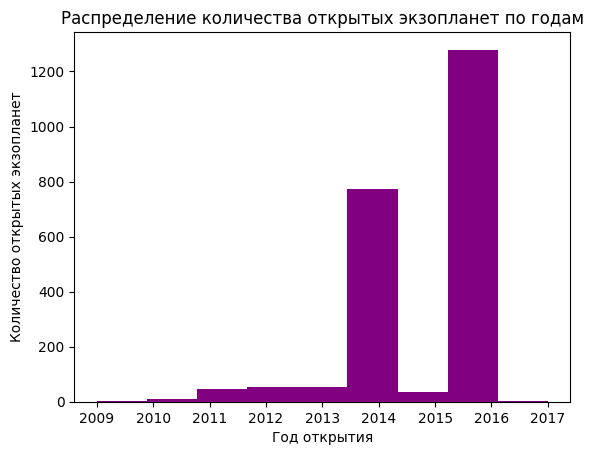

In [118]:
plt.hist(extra_df['disc_year'], bins=int(extra_df['disc_year'].max()-extra_df['disc_year'].min() + 1), color='purple')
plt.xlabel('Год открытия')
plt.ylabel('Количество открытых экзопланет')
plt.title('Распределение количества открытых экзопланет по годам')
plt.show()

Из гистограммы видно, что большая часть планет была открыта после 2014 года. Исторически причиной этого может служить изменение подхода к миссии Кеплера (из-за ряда техническим трудностей) в 2014 году, когда она была переосмысленна и названа "К2".

### Оценим распределение значений интервалов между транзитами.

In [168]:
df.describe()['period']

count      9200.000000
mean         74.315762
std        1360.612589
min           0.241843
25%           2.683239
50%           9.300443
75%          36.873842
max      129995.778400
Name: period, dtype: float64

Как видно, 75% объектов имеют значение интервала между транзитами равным менее 37 дней.

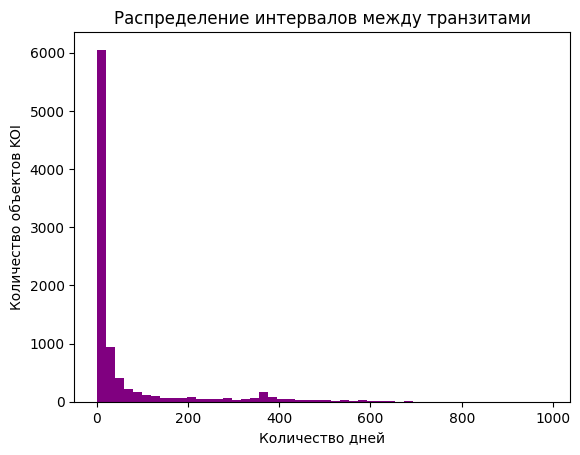

In [178]:

plt.hist(df[df['period'] < 1000.0]['period'], bins = 50, color='purple')
plt.xlabel('Количество дней')
plt.ylabel('Количество объектов KOI')
plt.title('Распределение интервалов между транзитами')
plt.show()


Значения интервалов имеют ощутимые выбросы, что затрудняет их визуализацию.

Визуализация радиусов KOI также не представляется возможной из-за больших выбросов и концентрации более половины значений ниже показателя 10 земных Радиусов.

In [181]:
df['prad'].describe()

count      9200.000000
mean        102.897725
std        3077.806350
min           0.080000
25%           1.400000
50%           2.390000
75%          14.930000
max      200346.000000
Name: prad, dtype: float64

### Построим столбчатую диаграмму распределения значений количества планет и звезд в системах с экзопланетами.

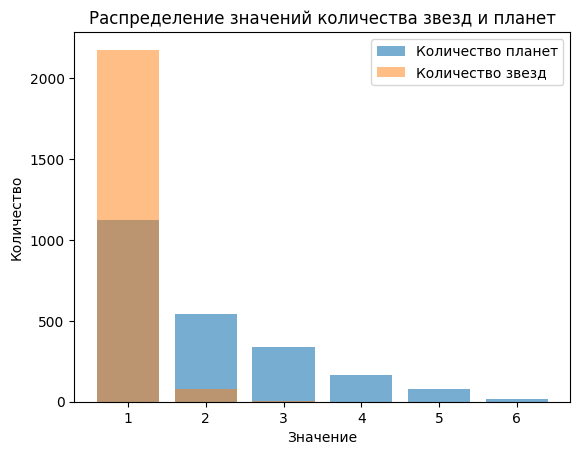

In [204]:
# Получим суммарное количество планет и звезд для каждого объекта
sy_snum_counts = extra_df['sy_snum'].value_counts()
sy_pnum_counts = extra_df['sy_pnum'].value_counts()

# Построим столбчатую диаграмму
plt.bar(sy_pnum_counts.index, sy_pnum_counts.values, alpha=0.6, label='Количество планет')
plt.bar(sy_snum_counts.index, sy_snum_counts.values, alpha=0.5, label='Количество звезд')
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.title('Распределение значений количества звезд и планет')
plt.legend()
plt.show()

Из данных видно, что количественно, больше всего систем с экзопланетами, в которых число планет равно 1, чем систем с другим количеством планет. Однако более чем в половине всех случаев, системы, в которых есть экзопланеты, также имеют еще несколько планет.

Случаи систем более чем с 1 звездой - редки.

### Построим гистограмму распределения значений температуры звезд, вокруг которых шел поиск экзопланет

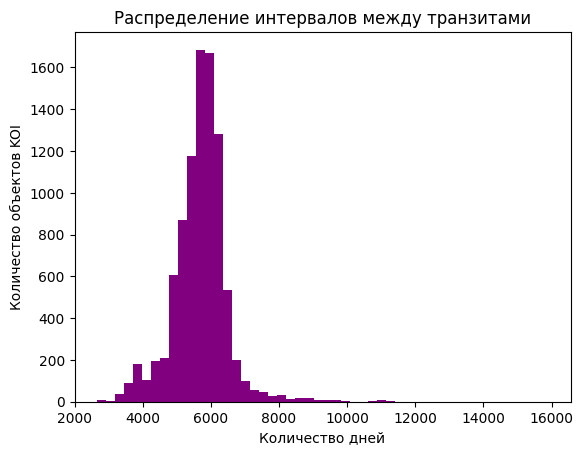

In [208]:
plt.hist(df['steff'], bins = 50, color='purple')
plt.xlabel('Количество дней')
plt.ylabel('Количество объектов KOI')
plt.title('Распределение интервалов между транзитами')
plt.show()

Как видим, распределение похоже на нормальное.

### Отобразим матрицу корреляций для наших данных

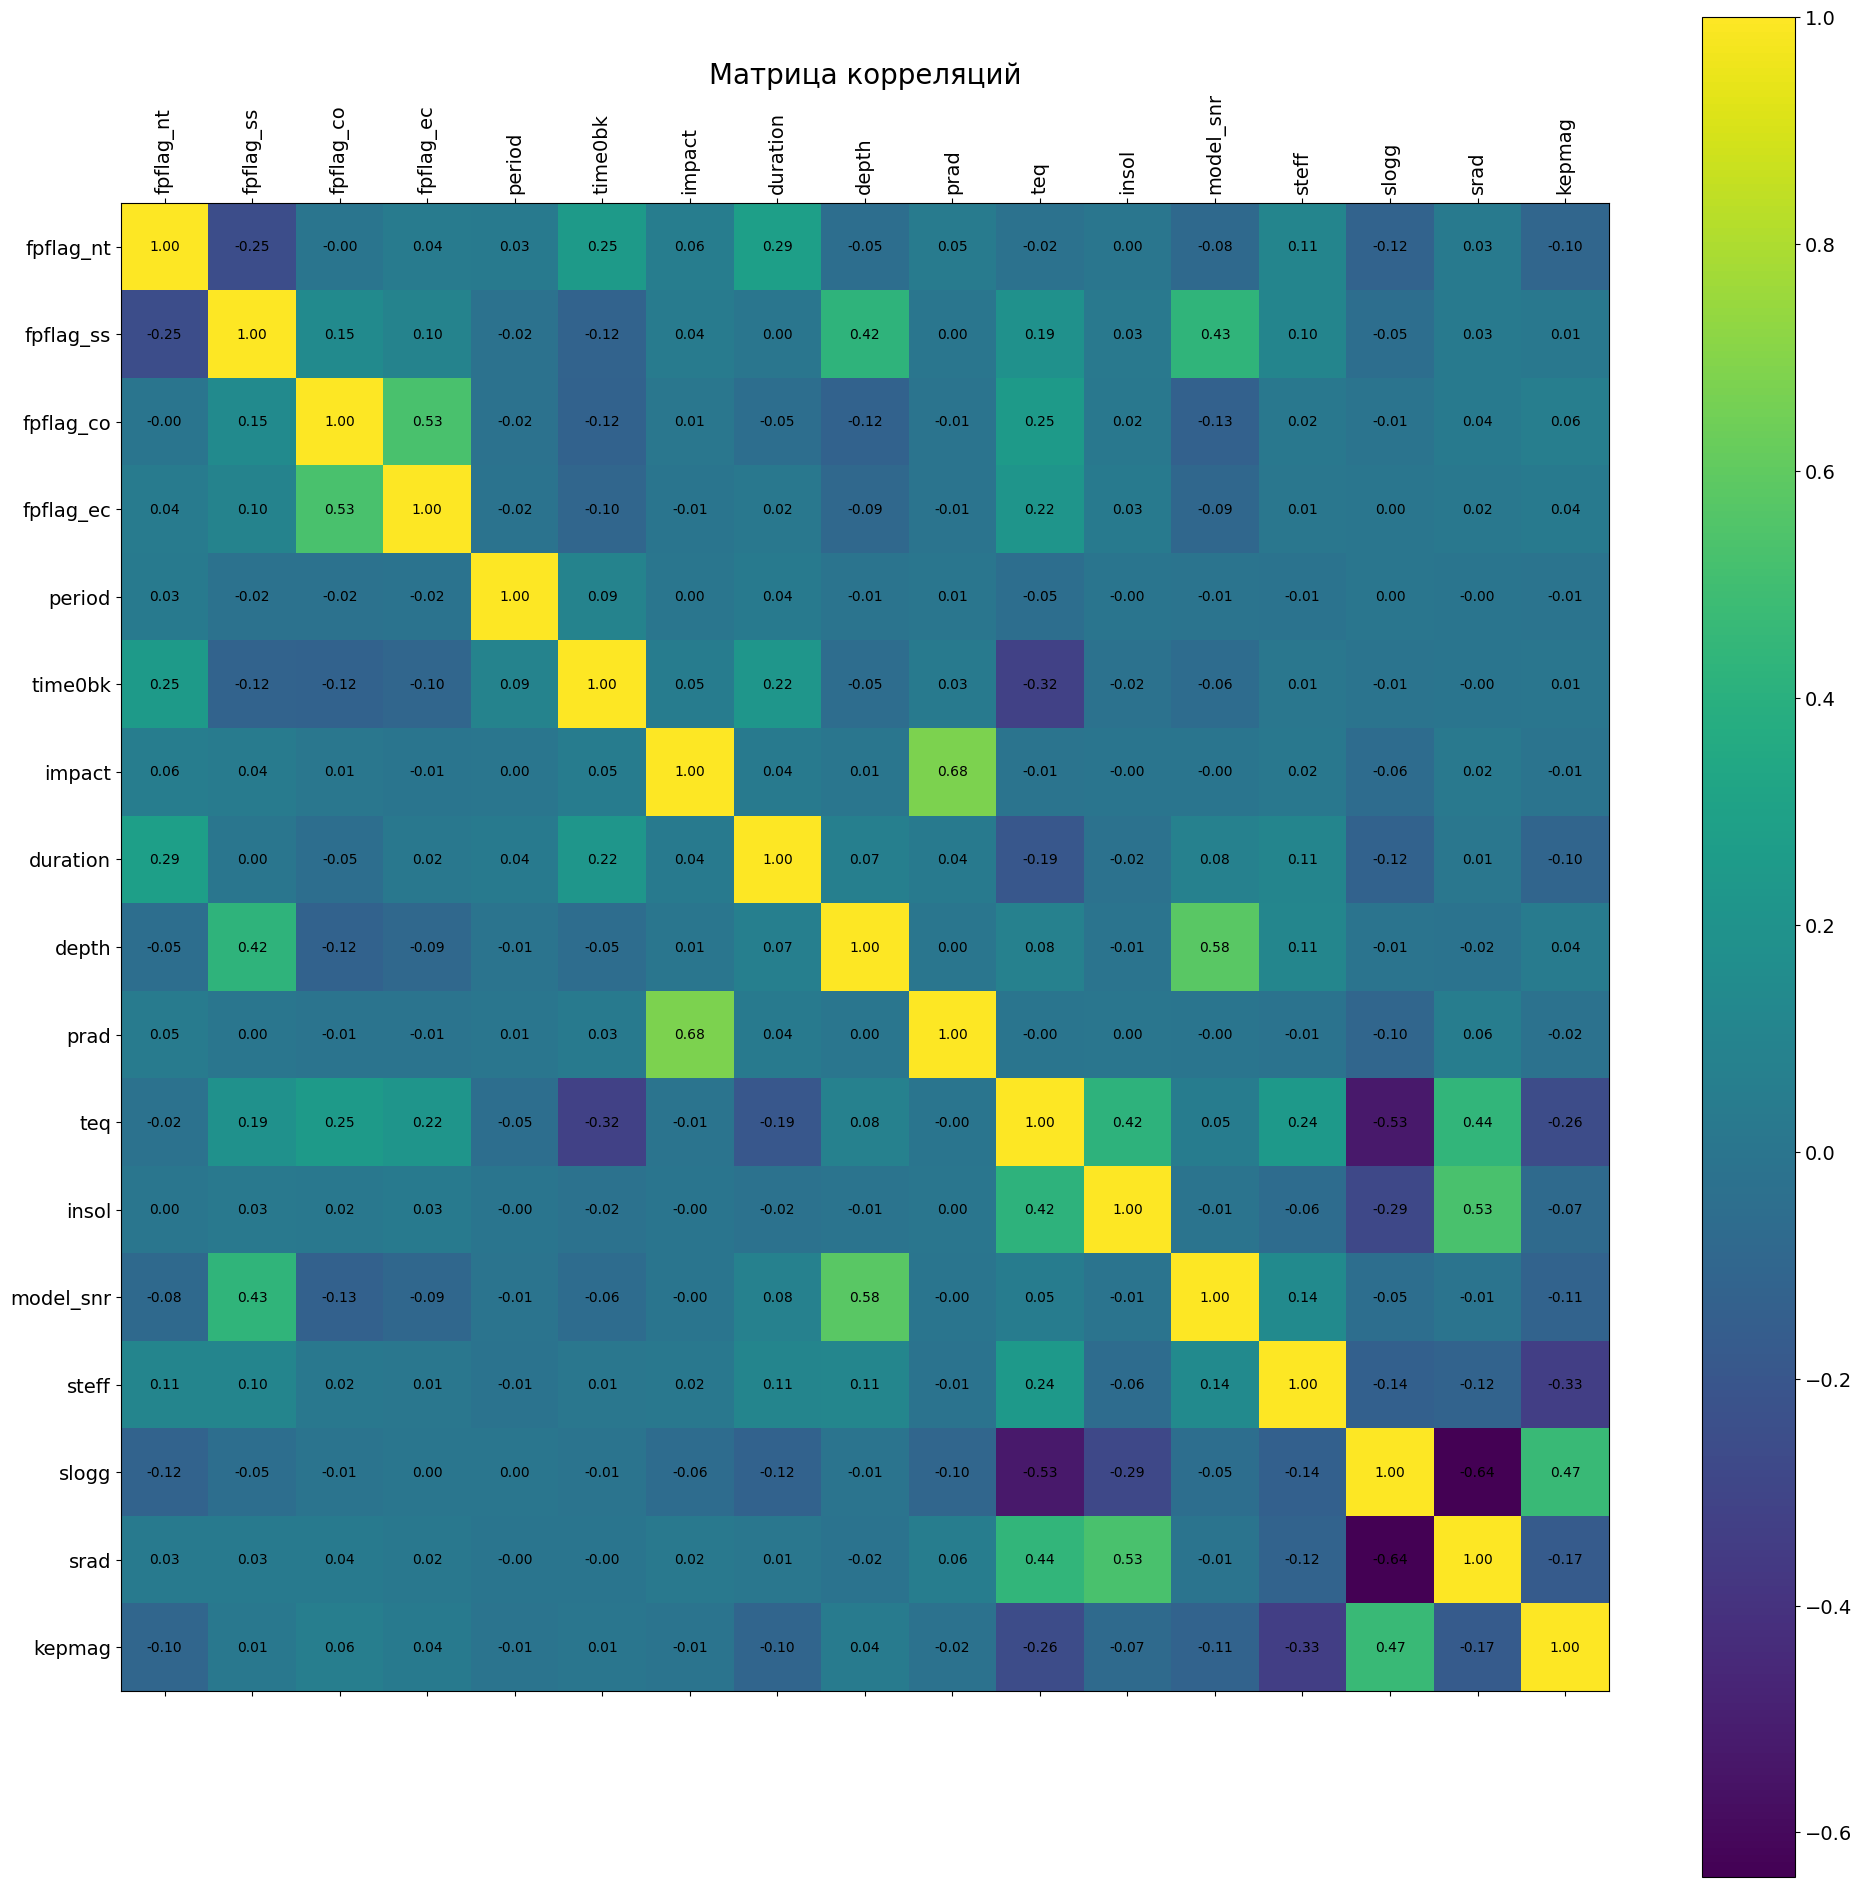

In [119]:
f = plt.figure(figsize=(24, 24))
plt.matshow(df.corr(numeric_only=True), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Матрица корреляций', fontsize=20);

for (i, j), z in np.ndenumerate(df.corr(numeric_only=True)):
    plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')


In [212]:

corr_matrix = df.corr(numeric_only=True)

# Находим самые коррелирующие пары переменных
corr_pairs = corr_matrix.unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort", ascending=False)

# Выводим самые коррелирующие пары переменных
print('Самые коррелирующие пары переменных:')
seen_pairs = set()
for pair, corr in sorted_pairs.items():
    var1, var2 = pair
    if var1 != var2 and corr != 1.0:
        if (var1, var2) not in seen_pairs and (var2, var1) not in seen_pairs:
            print(f'{var1} - {var2}: {corr:.2f}')
            seen_pairs.add((var1, var2))

Самые коррелирующие пары переменных:
impact - prad: 0.68
model_snr - depth: 0.58
srad - insol: 0.53
fpflag_ec - fpflag_co: 0.53
slogg - kepmag: 0.47
teq - srad: 0.44
fpflag_ss - model_snr: 0.43
fpflag_ss - depth: 0.42
insol - teq: 0.42
fpflag_nt - duration: 0.29
fpflag_nt - time0bk: 0.25
fpflag_co - teq: 0.25
steff - teq: 0.24
time0bk - duration: 0.22
teq - fpflag_ec: 0.22
fpflag_ss - teq: 0.19
fpflag_ss - fpflag_co: 0.15
model_snr - steff: 0.14
steff - depth: 0.11
fpflag_nt - steff: 0.11
duration - steff: 0.11
fpflag_ss - steff: 0.10
fpflag_ec - fpflag_ss: 0.10
time0bk - period: 0.09
model_snr - duration: 0.08
teq - depth: 0.08
depth - duration: 0.07
fpflag_co - kepmag: 0.06
srad - prad: 0.06
impact - fpflag_nt: 0.06
impact - time0bk: 0.05
teq - model_snr: 0.05
fpflag_nt - prad: 0.05
fpflag_ec - fpflag_nt: 0.04
fpflag_ss - impact: 0.04
kepmag - depth: 0.04
duration - period: 0.04
duration - impact: 0.04
srad - fpflag_co: 0.04
duration - prad: 0.04
fpflag_ec - kepmag: 0.04
prad - time0

In [40]:
from sklearn.ensemble import RandomForestClassifier

# Загрузка данных

# Выбор переменных, оканчивающихся на _err1 и _err2
err_cols = [col for col in df.columns if col.endswith('_err1') or col.endswith('_err2')]

# Подготовка данных для обучения
X = df[err_cols]
y = df['koi_disposition']

# Удаление строк с пустыми значениями
X.fillna(0, inplace=True)

# Кодирование категориальной переменной koi_disposition
y_encoded = pd.factorize(y)[0]

# Вычисление корреляции между переменными
correlations = {}
for col in X.columns:
    correlations[col] = sts.spearmanr(X[col], y_encoded)[0]

# Вывод корреляций
correlations = pd.Series(correlations)
correlations.sort_values(ascending=False, inplace=True)
print(correlations)

koi_duration_err1    0.236310
koi_time0bk_err1     0.216986
koi_srad_err1        0.168580
koi_steff_err1       0.152906
koi_period_err1      0.117056
koi_depth_err1       0.110466
koi_prad_err1        0.065773
koi_slogg_err1       0.028229
koi_impact_err2      0.027670
koi_impact_err1      0.017432
koi_insol_err1       0.015960
koi_insol_err2       0.004000
koi_prad_err2       -0.006719
koi_srad_err2       -0.072305
koi_depth_err2      -0.110466
koi_period_err2     -0.117056
koi_slogg_err2      -0.135826
koi_steff_err2      -0.157065
koi_time0bk_err2    -0.216986
koi_duration_err2   -0.236310
koi_teq_err1              NaN
koi_teq_err2              NaN
dtype: float64


C:\Users\kirill\AppData\Local\Temp\ipykernel_17256\3336231458.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)
c:\Users\kirill\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_stats_py.py:4921: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
